# ⚡️ Energy-Based Models

In this notebook, we'll walk through the steps required to train your own Energy Based Model to predict the distribution of a demo dataset

The code is adapted from the excellent ['Deep Energy-Based Generative Models' tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial8/Deep_Energy_Models.html) created by Phillip Lippe.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import tensorflow as tf
from tensorflow.keras import (
    datasets,
    layers,
    models,
    optimizers,
    activations,
    metrics,
    callbacks,
)

%cd /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks

from utils import display, sample_batch
import random

2023-07-31 18:06:39.925432: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 18:06:40.035836: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 18:06:40.036465: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 18:06:40.687080: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks


## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 60
LOAD_MODEL = False

In [3]:
# Load the data
(x_train, _), (x_test, _) = datasets.mnist.load_data()

In [4]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=-1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs # Image pixel values are now in [-1, 1]


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [5]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

2023-07-31 18:06:44.209849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 18:06:44.210260: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


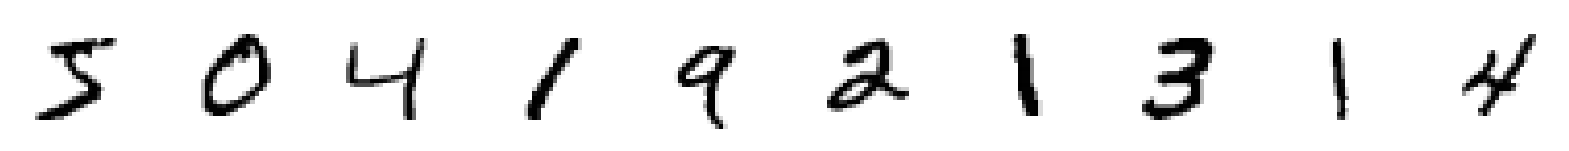

In [6]:
# Show some items of clothing from the training set
train_sample = sample_batch(x_train)
display(train_sample)

## 2. Build the EBM network <a name="train"></a>

## Mathematical Overview

### Basic Idea of Energy-Based Models

In an *Energy-Based Model* (EBM), the goal is to model the true data distribution $p_X(\mathbf{x})$ using a *Boltzman Distribution*, where $E(\mathbf{x})$ is the *Energy Function*.

The Boltzman Distribution is:

$$ p_X(\mathbf{x}) = \frac{\exp(-E(\mathbf{x}))}{\int_{\mathbf{\hat{x}} \in X} \exp(-E(\mathbf{\hat{x}}))} $$

In our case, we are going to train a neural network for our energy function, meaning $E(\mathbf{x}) = E_{\theta}(\mathbf{x})$. The idea is that when the energy is low, $p_X(\mathbf{x})$ is high, and vice versa. One issue, though, is that the normalizing denominator is high intractable. To sidestep this issue, we will use *Contrastive Divergence* during training and *Langevin Dynamics* for sampling. 

In this notebook, we are also going to introduce another activation function, the *Swish* activation:

$$ swish(\mathbf{x}) = \mathbf{x} \sigma (\mathbf{x}) = \frac{\mathbf{x}}{e^{-\mathbf{x}}+1} $$

This looks like the ReLU, but smooth:

<div style='text-align: center;'>
    <img src='/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/Graphics/Swish.png' alt='Swish' width='500'>
</div>

The energy function neural network is just a bunch of convolution layers that end in a dense layer with one output in the reals. 

### Sampling

Now, we might ask, how do we use this to generate samples, given we had a well-trained energy function? Well, we will do so by sampling some "image" from a random uniform distribution, as in, each pixel is drawn from $\mathcal{U}[-1.1]$. Now, because this is just noise, we expect it to have very high energy. We can then use gradient descent *not on the parameters themselves*, what we normally do for training, but *with respect to the input image*. The idea being that by iterating along the gradients of the input image so the energy function decreases, we will arrive at an image with a low energy, meaning it is *actually an image*. Formally, this is using *Langevin Dynamics*:

$$ \mathbf{x}^k = \mathbf{x}^{k-1} - \eta \nabla_{\mathbf{x}^{k-1}} E_{\theta}(\mathbf{x}^{k-1}) + \omega $$

In the above, $\mathbf{x}^0 \sim \mathcal{U}[-1,1]$ and $\omega \sim \mathcal{N}(0,\sigma)$.

### Loss

Normally, we would want to minimize the negative log-likelihood:

$$ \mathcal{L}_{NLL} = - \mathbb{E}_{\mathbf{x} \sim p_{\theta}(\mathbf{x})} [\log p_{\theta}(\mathbf{x})] $$

When $p_{\theta}(\mathbf{x})$ is a Boltzman distribution, it can be shown that the gradient is:

$$ \nabla_{\theta} \mathcal{L}_{NLL} = \mathbb{E}_{\mathbf{x} \sim p_{\theta}(\mathbf{x})} [\nabla_{\theta}E_{\theta}(\mathbf{x})] - \mathbb{E}_{\mathbf{x} \sim Model} [\nabla_{\theta}E_{\theta}(\mathbf{x})] $$ 

Now, we can consider $\mathbf{x} \sim p_{\theta}(\mathbf{x})$ the *fake* images due to how they're sampled. We would like to sample from $p_{\theta}(\mathbf{x})$ directly, but we can't so we will have to generate them from the Langevin sampling procedure described earlier. Thus, they are fake. We will also keep a batch of sampled images in a buffer so we don't have to do this process from scratch each time. This loss, called *Contrastive Divergence*, gets its name from the idea that we want a large contrast between the fake images and the real ones, indicating the model knowns the difference between them. 

In [7]:
# Model

ebm_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(
    16, kernel_size=5, strides=2, padding="same", activation=activations.swish # New activation function
)(ebm_input)
x = layers.Conv2D(
    32, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation=activations.swish)(x)
ebm_output = layers.Dense(1)(x) # Final number is a real-valued scalar
model = models.Model(ebm_input, ebm_output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448 

In [8]:
if LOAD_MODEL:
    model.load_weights("./models/model.h5")

## 2. Set up a Langevin sampler function <a name="sampler"></a>

In [9]:
# Function to generate samples using Langevin Dynamics
def generate_samples(
    model, inp_imgs, steps, step_size, noise, return_img_per_step=False
):
    imgs_per_step = []
    for _ in range(steps):
        inp_imgs += tf.random.normal(inp_imgs.shape, mean=0, stddev=noise) # Random-noise images
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0) # The real images have pixel values in [-1,1], so we clip here
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs) # Recall we are going to need the gradients with respect to the images, so we let the model know
            out_score = model(inp_imgs) # Output energy values
        grads = tape.gradient(out_score, inp_imgs) # Gradients of the energy function with respect to the images
        grads = tf.clip_by_value(grads, -GRADIENT_CLIP, GRADIENT_CLIP) # Keeping the gradients within a range
        inp_imgs += step_size * grads # From the equation
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0) # Clipping the pixel values again
        if return_img_per_step:
            imgs_per_step.append(inp_imgs)
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return inp_imgs # We want the images out of this

## 3. Set up a buffer to store examples <a name="buffer"></a>

In [10]:
class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.examples = [
            tf.random.uniform(shape=(1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2
            - 1
            for _ in range(BATCH_SIZE)
        ] # Random images where each pixel values is in [-1,1]

    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05) # Sampling 5% as brand new images. The rest are from the buffer. This tells us how many new images to create
        rand_imgs = (
            tf.random.uniform((n_new, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
        ) # Random images where each pixel values is in [-1,1]
        old_imgs = tf.concat(
            random.choices(self.examples, k=BATCH_SIZE - n_new), axis=0
        ) # Sampling from the examples already in the buffer
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0) # Full batch size of images, new and old
        inp_imgs = generate_samples(
            self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise
        ) # Generating fake images through the Langevin sampling, beginning with the noise we created and sampled from
        self.examples = tf.split(inp_imgs, BATCH_SIZE, axis=0) + self.examples
        self.examples = self.examples[:BUFFER_SIZE]
        return inp_imgs

In [11]:
class EBM(models.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA
        self.loss_metric = metrics.Mean(name="loss")
        self.reg_loss_metric = metrics.Mean(name="reg")
        self.cdiv_loss_metric = metrics.Mean(name="cdiv")
        self.real_out_metric = metrics.Mean(name="real")
        self.fake_out_metric = metrics.Mean(name="fake")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(
            shape=tf.shape(real_imgs), mean=0, stddev=NOISE
        ) # Adding a bit of noise to the real images so the model doesn't memorize them
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0) # Clipping so the pixel values are in [-1,1]
        fake_imgs = self.buffer.sample_new_exmps(
            steps=STEPS, step_size=STEP_SIZE, noise=NOISE
        ) # Getting some fake images
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0) # We are going to feed the model everything together
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0) # Getting the model outputs on the real and the fake, then dividing the outputs up
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
                real_out, axis=0
            ) # Getting the average of each sets' energy values
            reg_loss = self.alpha * tf.reduce_mean(
                real_out**2 + fake_out**2, axis=0
            ) # A regularization
            loss = cdiv_loss + reg_loss # Loss is a combination of contrastive divergence and the regularizer
        grads = training_tape.gradient(loss, self.model.trainable_variables) # Notice the difference in the gradients here versus in the sampling function
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs): # Basically the same steps
        batch_size = real_imgs.shape[0]
        fake_imgs = (
            tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
            * 2
            - 1
        ) # Just noise this time, no sampling to generate new images
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0) # In this case, it is real images versus noise, not generated images
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
            real_out, axis=0
        )
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics[2:]}

In [12]:
ebm = EBM()

## 3. Train the EBM network <a name="train"></a>

In [13]:
# Compile and train the model
ebm.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True
)

In [18]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            start_imgs = (
                np.random.uniform(
                    size=(self.num_img, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
                )
                * 2
                - 1
            )
            generated_images = generate_samples(
                ebm.model,
                start_imgs,
                steps=1000,
                step_size=STEP_SIZE,
                noise=NOISE,
                return_img_per_step=False,
            )
            generated_images = generated_images.numpy()
            display(
                generated_images,
                save_to="/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/07_ebm/01_ebm/output/generated_img_%03d.png" % (epoch),
            )

            example_images = tf.concat(
                random.choices(ebm.buffer.examples, k=10), axis=0
            )
            example_images = example_images.numpy()
            display(
                example_images, save_to="/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/07_ebm/01_ebm/output/example_img_%03d.png" % (epoch)
            )


image_generator_callback = ImageGenerator(num_img=10)

In [19]:
class SaveModel(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model.save_weights("./models/model.h5")


save_model_callback = SaveModel()

Epoch 1/60


469/469 [==============================] - ETA: 0s - loss: -0.0059 - reg: 0.0019 - cdiv: -0.0078 - real: 0.0155 - fake: 0.0076
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/07_ebm/01_ebm/output/generated_img_000.png


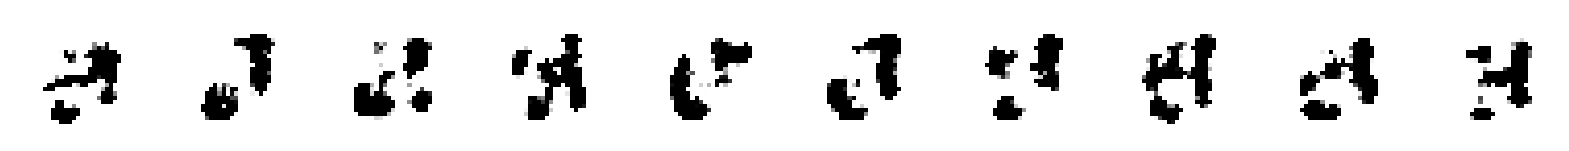


Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/07_ebm/01_ebm/output/example_img_000.png


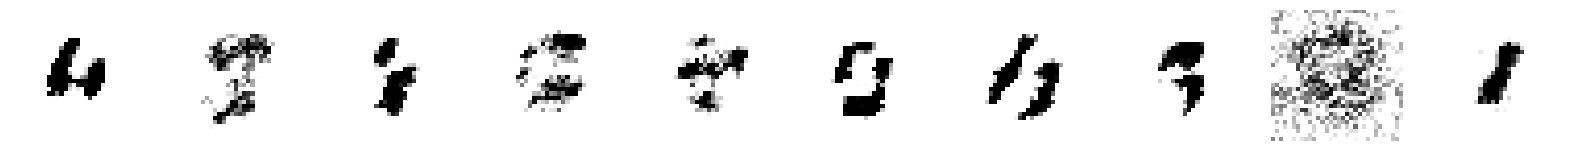

469/469 [==============================] - 594s 1s/step - loss: -0.0059 - reg: 0.0019 - cdiv: -0.0078 - real: 0.0155 - fake: 0.0076 - val_cdiv: -1.6782 - val_real: -0.0617 - val_fake: -1.7399
Epoch 2/60
469/469 [==============================] - 579s 1s/step - loss: -0.0011 - reg: 0.0012 - cdiv: -0.0023 - real: 0.0037 - fake: 0.0015 - val_cdiv: -1.9316 - val_real: -0.0491 - val_fake: -1.9806
Epoch 3/60
469/469 [==============================] - 576s 1s/step - loss: 4.0426e-04 - reg: 6.8598e-04 - cdiv: -2.8171e-04 - real: 0.0015 - fake: 0.0012 - val_cdiv: -2.0331 - val_real: -0.0438 - val_fake: -2.0770
Epoch 4/60
469/469 [==============================] - 573s 1s/step - loss: 1.2146e-04 - reg: 4.3290e-04 - cdiv: -3.1144e-04 - real: 0.0015 - fake: 0.0012 - val_cdiv: -2.2761 - val_real: -0.0190 - val_fake: -2.2951
Epoch 5/60
469/469 [==============================] - 575s 1s/step - loss: 3.5470e-04 - reg: 3.1429e-04 - cdiv: 4.0409e-05 - real: 8.8631e-04 - fake: 9.2672e-04 - val_cdiv: -2.4

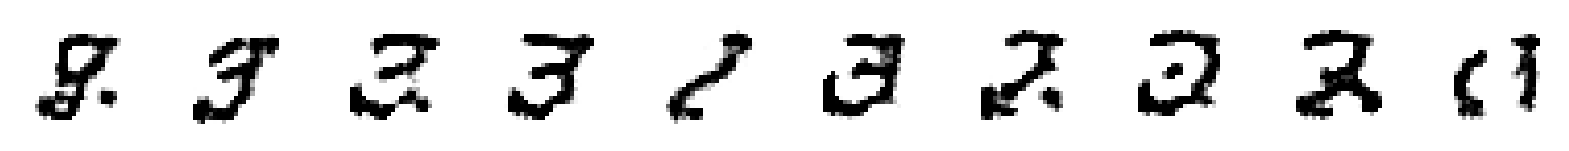


Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/07_ebm/01_ebm/output/example_img_010.png


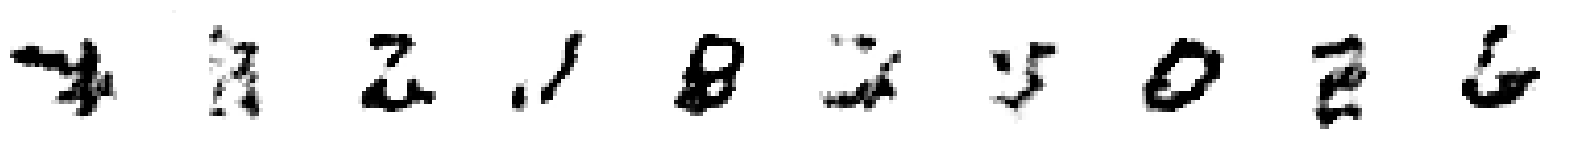

469/469 [==============================] - 573s 1s/step - loss: 1.9510e-04 - reg: 2.7790e-04 - cdiv: -8.2802e-05 - real: 0.0012 - fake: 0.0011 - val_cdiv: -4.4835 - val_real: 0.0169 - val_fake: -4.4666
Epoch 12/60
469/469 [==============================] - 563s 1s/step - loss: 4.4577e-04 - reg: 2.2416e-04 - cdiv: 2.2161e-04 - real: 3.7934e-04 - fake: 6.0095e-04 - val_cdiv: -4.7191 - val_real: 0.0146 - val_fake: -4.7045
Epoch 13/60
469/469 [==============================] - 567s 1s/step - loss: 1.0885e-04 - reg: 2.1753e-04 - cdiv: -1.0868e-04 - real: 5.1074e-04 - fake: 4.0206e-04 - val_cdiv: -5.1877 - val_real: 0.0121 - val_fake: -5.1757
Epoch 14/60
469/469 [==============================] - 567s 1s/step - loss: -2.3806e-05 - reg: 2.6415e-04 - cdiv: -2.8795e-04 - real: 0.0012 - fake: 8.7673e-04 - val_cdiv: -5.7046 - val_real: 0.0211 - val_fake: -5.6835
Epoch 15/60
469/469 [==============================] - 560s 1s/step - loss: -1.6978e-04 - reg: 2.1490e-04 - cdiv: -3.8468e-04 - real: 8.

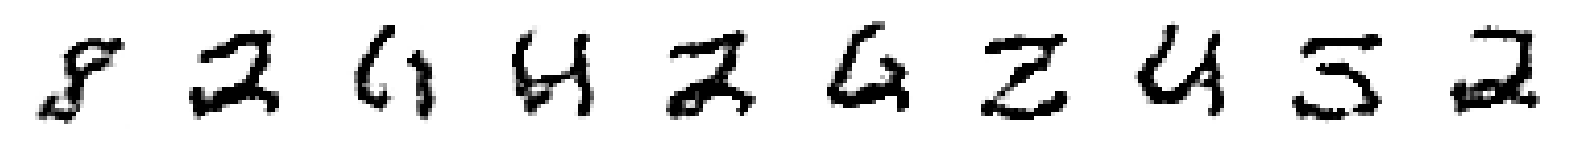


Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/07_ebm/01_ebm/output/example_img_020.png


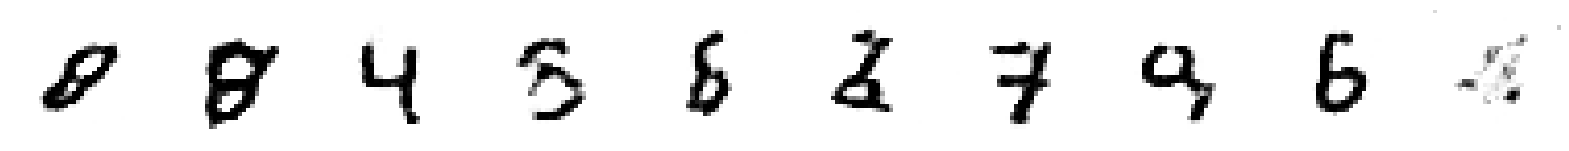

469/469 [==============================] - 579s 1s/step - loss: -8.8768e-05 - reg: 1.9972e-04 - cdiv: -2.8849e-04 - real: 7.1996e-04 - fake: 4.3147e-04 - val_cdiv: -8.9131 - val_real: 0.0288 - val_fake: -8.8843
Epoch 22/60
469/469 [==============================] - 586s 1s/step - loss: -5.0384e-05 - reg: 1.9457e-04 - cdiv: -2.4496e-04 - real: 6.8242e-04 - fake: 4.3746e-04 - val_cdiv: -9.4602 - val_real: 0.0289 - val_fake: -9.4312
Epoch 23/60
469/469 [==============================] - 565s 1s/step - loss: 2.3622e-04 - reg: 1.8355e-04 - cdiv: 5.2671e-05 - real: 4.8123e-04 - fake: 5.3390e-04 - val_cdiv: -9.7013 - val_real: 0.0169 - val_fake: -9.6845
Epoch 24/60
469/469 [==============================] - 568s 1s/step - loss: -1.8871e-04 - reg: 1.5367e-04 - cdiv: -3.4238e-04 - real: 7.8351e-04 - fake: 4.4113e-04 - val_cdiv: -10.2613 - val_real: 0.0211 - val_fake: -10.2402
Epoch 25/60
469/469 [==============================] - 563s 1s/step - loss: -2.7006e-05 - reg: 1.5721e-04 - cdiv: -1.842

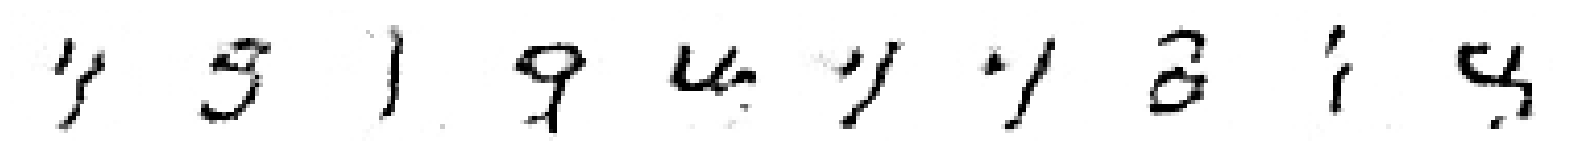


Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/07_ebm/01_ebm/output/example_img_030.png


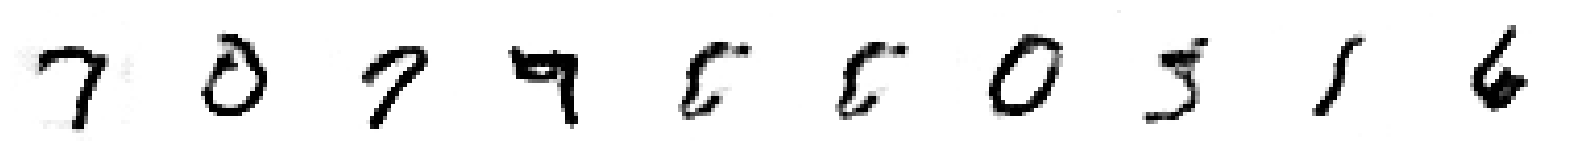

469/469 [==============================] - 571s 1s/step - loss: 6.4263e-05 - reg: 1.3288e-04 - cdiv: -6.8612e-05 - real: 8.1159e-04 - fake: 7.4298e-04 - val_cdiv: -13.7147 - val_real: 0.0193 - val_fake: -13.6953
Epoch 32/60
469/469 [==============================] - 561s 1s/step - loss: -5.5961e-05 - reg: 1.3780e-04 - cdiv: -1.9376e-04 - real: 6.5607e-04 - fake: 4.6230e-04 - val_cdiv: -13.8925 - val_real: -5.8347e-04 - val_fake: -13.8931
Epoch 33/60
469/469 [==============================] - 559s 1s/step - loss: -1.3399e-05 - reg: 1.2866e-04 - cdiv: -1.4206e-04 - real: 3.8606e-04 - fake: 2.4400e-04 - val_cdiv: -14.4921 - val_real: 0.0098 - val_fake: -14.4822
Epoch 34/60
469/469 [==============================] - 560s 1s/step - loss: 1.5311e-04 - reg: 1.0902e-04 - cdiv: 4.4094e-05 - real: 3.6738e-04 - fake: 4.1148e-04 - val_cdiv: -14.9618 - val_real: 0.0077 - val_fake: -14.9541
Epoch 35/60
469/469 [==============================] - 560s 1s/step - loss: -1.2781e-04 - reg: 1.1836e-04 - cd

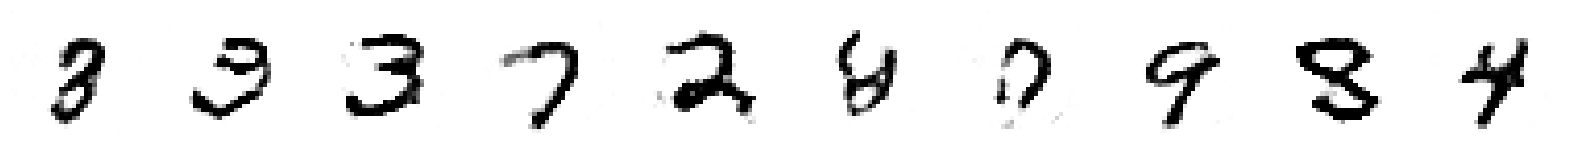


Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/07_ebm/01_ebm/output/example_img_040.png


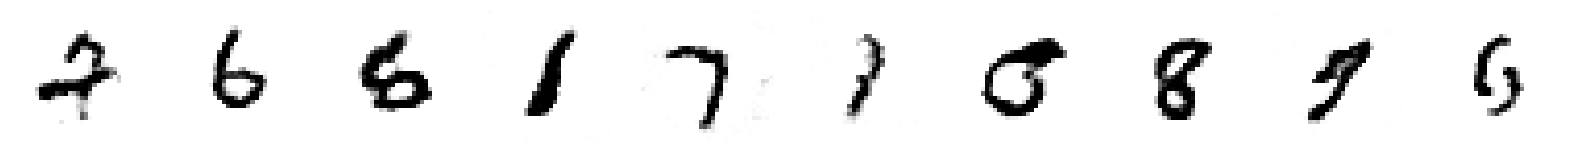

469/469 [==============================] - 572s 1s/step - loss: 9.1594e-05 - reg: 9.1429e-05 - cdiv: 1.6497e-07 - real: 5.0826e-04 - fake: 5.0843e-04 - val_cdiv: -17.0864 - val_real: 9.8700e-04 - val_fake: -17.0854
Epoch 42/60
469/469 [==============================] - 558s 1s/step - loss: -1.6523e-06 - reg: 1.0226e-04 - cdiv: -1.0392e-04 - real: 2.0044e-04 - fake: 9.6527e-05 - val_cdiv: -17.9680 - val_real: 0.0110 - val_fake: -17.9570
Epoch 43/60
469/469 [==============================] - 561s 1s/step - loss: 5.4658e-05 - reg: 1.0369e-04 - cdiv: -4.9037e-05 - real: 3.5668e-04 - fake: 3.0765e-04 - val_cdiv: -18.0040 - val_real: 4.2048e-05 - val_fake: -18.0040
Epoch 44/60
469/469 [==============================] - 561s 1s/step - loss: -1.1189e-04 - reg: 1.2331e-04 - cdiv: -2.3519e-04 - real: 3.5482e-04 - fake: 1.1963e-04 - val_cdiv: -18.1778 - val_real: 0.0050 - val_fake: -18.1728
Epoch 45/60
469/469 [==============================] - 559s 1s/step - loss: 3.1967e-04 - reg: 1.1337e-04 - 

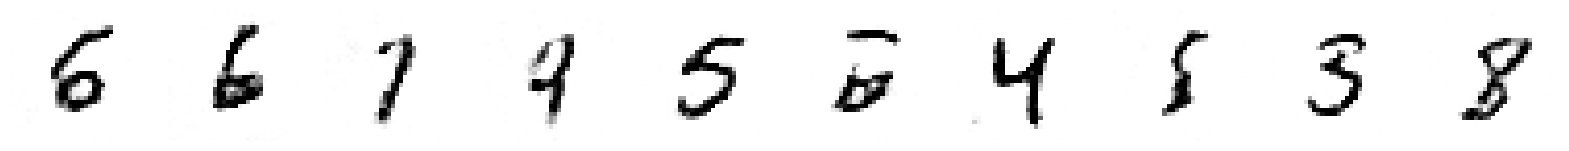


Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/07_ebm/01_ebm/output/example_img_050.png


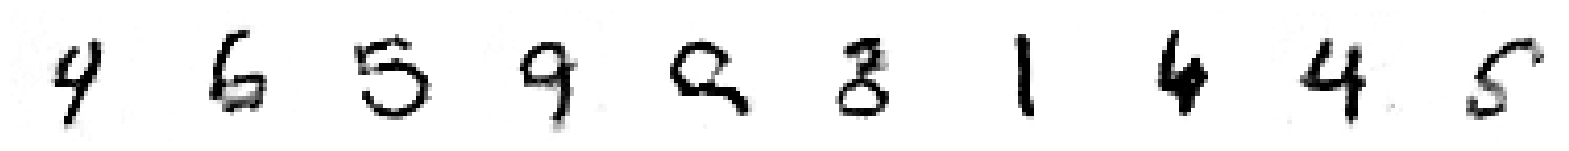

469/469 [==============================] - 567s 1s/step - loss: 1.0674e-04 - reg: 9.9056e-05 - cdiv: 7.6886e-06 - real: 1.5349e-05 - fake: 2.3037e-05 - val_cdiv: -19.0738 - val_real: -0.0015 - val_fake: -19.0753
Epoch 52/60
469/469 [==============================] - 557s 1s/step - loss: -1.5769e-05 - reg: 8.7488e-05 - cdiv: -1.0326e-04 - real: 3.2030e-05 - fake: -7.1226e-05 - val_cdiv: -19.2331 - val_real: 0.0114 - val_fake: -19.2216
Epoch 53/60
469/469 [==============================] - 558s 1s/step - loss: 1.1765e-04 - reg: 1.0165e-04 - cdiv: 1.5999e-05 - real: 1.6590e-04 - fake: 1.8190e-04 - val_cdiv: -18.4219 - val_real: -0.0026 - val_fake: -18.4246
Epoch 54/60
469/469 [==============================] - 556s 1s/step - loss: 3.2035e-05 - reg: 1.0894e-04 - cdiv: -7.6908e-05 - real: 2.2457e-04 - fake: 1.4766e-04 - val_cdiv: -18.9961 - val_real: 0.0030 - val_fake: -18.9931
Epoch 55/60
469/469 [==============================] - 559s 1s/step - loss: 1.8711e-04 - reg: 1.0115e-04 - cdiv: 8

In [20]:
ebm.fit(
    x_train,
    shuffle=True,
    epochs=60,
    validation_data=x_test,
    callbacks=[
        save_model_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)

## 4. Generate images <a name="generate"></a>

In [21]:
start_imgs = (
    np.random.uniform(size=(10, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
)

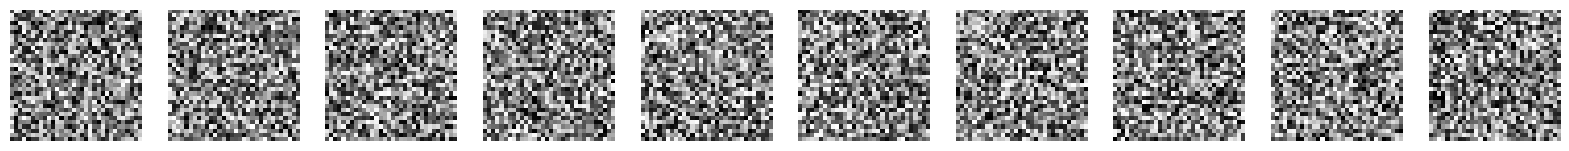

In [22]:
display(start_imgs)

In [23]:
gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=1000,
    step_size=STEP_SIZE,
    noise=NOISE,
    return_img_per_step=True,
)

In [ ]:
display(gen_img[-1].numpy())

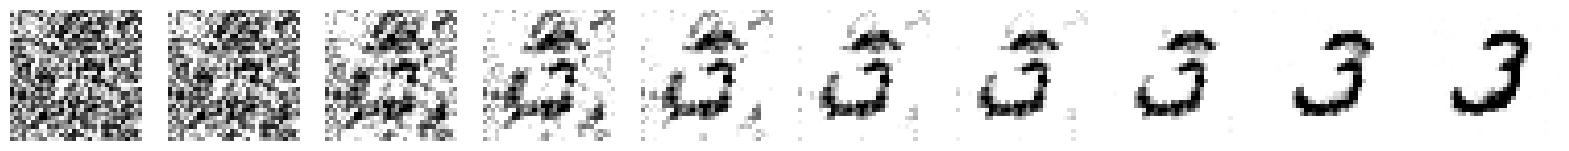

In [24]:
imgs = []
for i in [0, 1, 3, 5, 10, 30, 50, 100, 300, 999]:
    imgs.append(gen_img[i].numpy()[6])

display(np.array(imgs))